# Gradient Boosting: a practical guide

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

## An example: the california housing dataset

In [4]:
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import median_absolute_error


calhousing = fetch_california_housing()

X, y = calhousing.data, calhousing.target

In [5]:
print(calhousing.DESCR)

California housing dataset.

The original database is available from StatLib

    http://lib.stat.cmu.edu/

The data contains 20,640 observations on 9 variables.

This dataset contains the average house value as target variable
and the following input variables (features): average income,
housing average age, average rooms, average bedrooms, population,
average occupation, latitude, and longitude in that order.

References
----------

Pace, R. Kelley and Ronald Barry, Sparse Spatial Autoregressions,
Statistics and Probability Letters, 33 (1997) 291-297.




In [6]:
print(calhousing.feature_names)

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1000, random_state=0)

Let's start with a quick baseline model: linear regression (aka. Ordinary Least Squares):

In [52]:
%%time
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

lm = LinearRegression().fit(X_train, y_train)

print("train error: %0.3f, test error: %0.3f" %
      (median_absolute_error(y_train, lm.predict(X_train)),
       median_absolute_error(y_test, lm.predict(X_test))))

train error: 0.413, test error: 0.419
CPU times: user 28 ms, sys: 4 ms, total: 32 ms
Wall time: 20.9 ms


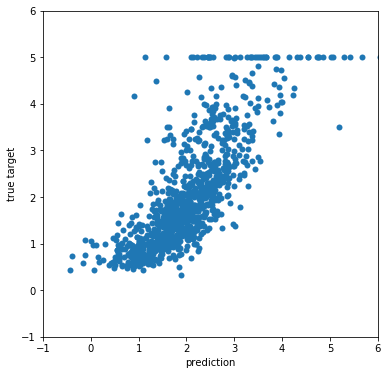

In [53]:
def scatter_predictions(y_pred, y_true):
    plt.figure(figsize=(6, 6))
    plt.xlabel('prediction')
    plt.ylabel('true target')
    plt.xlim(-1, 6)
    plt.ylim(-1, 6)
    plt.scatter(y_pred, y_true)
    
scatter_predictions(lm.predict(X_test), y_test)

This is pretty bad: the errors (off-diagonal predictions) seems to be heteroschedastic and there is a saturation effect with many samples with `y_true == 5`. Let's check:

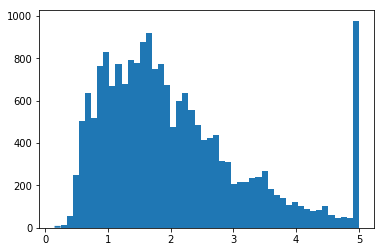

In [13]:
plt.hist(y_train, bins=50);

We can filter out the "anomalies" and make the target variable marginal distribution more "Gaussian" by taking the log:

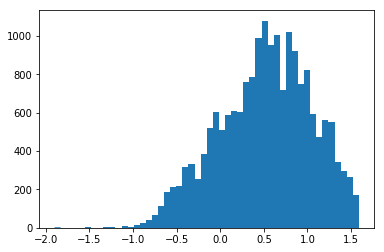

In [95]:
plt.hist(np.log(y_train[y_train < 4.9]), bins=50);

In [54]:
%%time
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


lm2 = make_pipeline(StandardScaler(), LinearRegression())
lm2.fit(X_train[y_train < 4.9], np.log(y_train[y_train < 4.9]))

print("train error: %0.3f, test error: %0.3f" %
      (median_absolute_error(y_train[y_train < 4.9],
                             np.exp(lm2.predict(X_train[y_train < 4.9]))),
       median_absolute_error(y_test[y_test < 4.9],
                             np.exp(lm2.predict(X_test[y_test < 4.9])))))

train error: 0.325, test error: 0.340
CPU times: user 40 ms, sys: 36 ms, total: 76 ms
Wall time: 44.6 ms


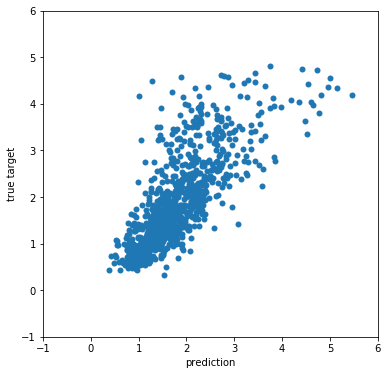

In [55]:
scatter_predictions(
    np.exp(lm2.predict(X_test[y_test < 4.9])),
    y_test[y_test < 4.9])

In [56]:
%%time
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_union

plm = make_pipeline(
    StandardScaler(),
    make_union(
        FunctionTransformer(lambda x: x),
        PolynomialFeatures(degree=4)
    ),
    LinearRegression())
plm.fit(X_train[y_train < 4.9], np.log(y_train[y_train < 4.9]))

print("train error: %0.3f, test error: %0.3f" %
      (median_absolute_error(y_train[y_train < 4.9],
                             np.exp(plm.predict(X_train[y_train < 4.9]))),
       median_absolute_error(y_test[y_test < 4.9],
                             np.exp(plm.predict(X_test[y_test < 4.9])))))

train error: 0.231, test error: 0.242
CPU times: user 6.08 s, sys: 4.24 s, total: 10.3 s
Wall time: 4.18 s


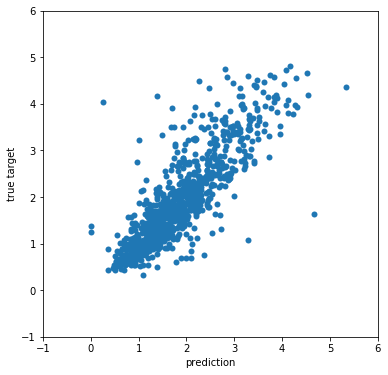

In [57]:
scatter_predictions(
    np.exp(plm.predict(X_test[y_test < 4.9])),
    y_test[y_test < 4.9])

In [24]:
%%time
from sklearn.neural_network import MLPRegressor

mlp = make_pipeline(
    StandardScaler(),
    MLPRegressor(hidden_layer_sizes=(100, 10, 10), activation='relu'),
)
mlp.fit(X_train[y_train < 4.9], np.log(y_train[y_train < 4.9]))

print("train error: %0.3f, test error: %0.3f" %
      (median_absolute_error(y_train[y_train < 4.9],
                             np.exp(mlp.predict(X_train[y_train < 4.9]))),
       median_absolute_error(y_test[y_test < 4.9],
                             np.exp(mlp.predict(X_test[y_test < 4.9])))))

train error: 0.215, test error: 0.223
CPU times: user 7.61 s, sys: 188 ms, total: 7.8 s
Wall time: 7.6 s


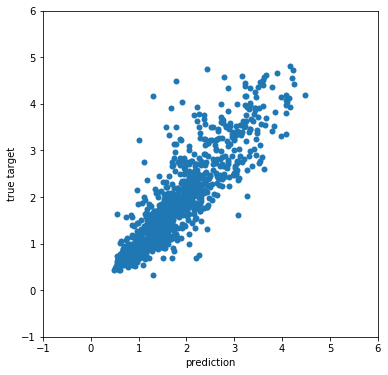

In [96]:
scatter_predictions(
    np.exp(mlp.predict(X_test[y_test < 4.9])),
    y_test[y_test < 4.9])

In [102]:
%%time
gbr = GradientBoostingRegressor(learning_rate=0.1, max_depth=8, min_samples_leaf=3,
                                n_estimators=50, loss='huber')
gbr.fit(X_train, y_train)
print("train error: %0.3f, test error: %0.3f" %
      (median_absolute_error(y_train, gbr.predict(X_train)),
       median_absolute_error(y_test, gbr.predict(X_test))))

train error: 0.146, test error: 0.192
CPU times: user 3.65 s, sys: 0 ns, total: 3.65 s
Wall time: 3.65 s


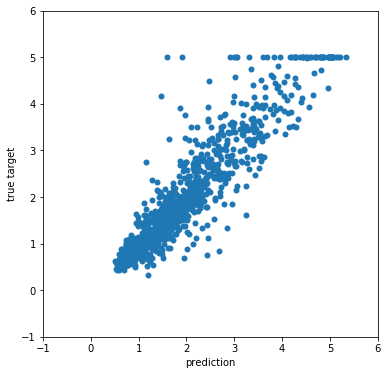

In [103]:
scatter_predictions(gbr.predict(X_test), y_test)

In [64]:
from pickle import dumps
print("Model size: %0.1f MB" % (len(dumps(gbr)) / 1e6))

Model size: 1.3 MB


In [46]:
%time _ = gbr.predict(X_test[:100])

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 2.59 ms


In [66]:
%%time
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=50, n_jobs=-1)
rfr.fit(X_train, y_train)
print("train error: %0.3f, test error: %0.3f" %
      (median_absolute_error(y_train, rfr.predict(X_train)),
       median_absolute_error(y_test, rfr.predict(X_test))))

train error: 0.074, test error: 0.191
CPU times: user 29.2 s, sys: 76 ms, total: 29.3 s
Wall time: 8.14 s


In [67]:
print("Model size: %0.1f MB" % (len(dumps(rfr)) / 1e6))

Model size: 76.1 MB


In [68]:
%time _ = rfr.predict(X_test[:100])

CPU times: user 56 ms, sys: 8 ms, total: 64 ms
Wall time: 104 ms


### Explaining what the model learned

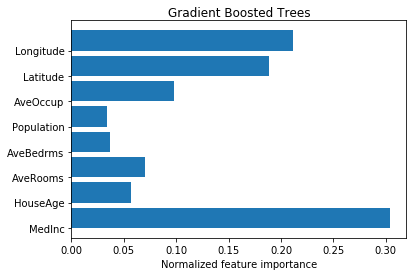

In [109]:
plt.barh(np.arange(X_train.shape[1]), gbr.feature_importances_,
         tick_label=calhousing.feature_names)
plt.xlabel("Normalized feature importance")
plt.title("Gradient Boosted Trees");

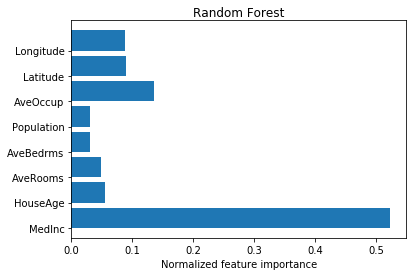

In [108]:
plt.barh(np.arange(X_train.shape[1]), rfr.feature_importances_,
         tick_label=calhousing.feature_names)
plt.xlabel("Normalized feature importance")
plt.title("Random Forest");

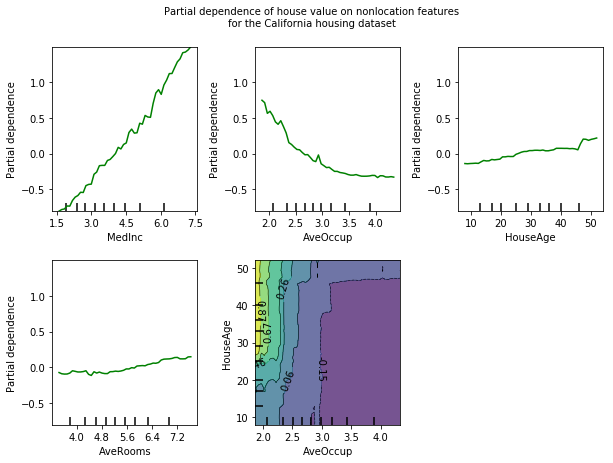

In [160]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence

features = [0, 5, 1, 2, (5, 1)]
fig, axs = plot_partial_dependence(gbr, X_train, features,
                                   feature_names=calhousing.feature_names,
                                   n_jobs=-1, grid_resolution=50,
                                   figsize=(9, 7))
fig.suptitle('Partial dependence of house value on nonlocation features\n'
             'for the California housing dataset')
plt.subplots_adjust(top=0.9)

## Tricks

### Warm started models

In [156]:
X_train_small, X_val, y_train_small, y_val = train_test_split(
    X_train, y_train, train_size=5000, test_size=1000)

val_errors = []
train_errors = []


gbr = GradientBoostingRegressor(learning_rate=0.1, max_depth=8, min_samples_leaf=3,
                                n_estimators=1)

gbr.fit(X_train_small, y_train_small)

train_error = median_absolute_error(y_train, gbr.predict(X_train))
val_error = median_absolute_error(y_test, gbr.predict(X_test))

train_errors.append(train_error)
val_errors.append(val_error)

print("train error: %0.3f, test error: %0.3f" % (train_error, val_error)) 

train error: 0.710, test error: 0.776


In [157]:
for i in range(100):
    gbr.set_params(warm_start=True, n_estimators=len(gbr.estimators_) + 1)
    gbr.fit(X_train_small, y_train_small)
    train_error = median_absolute_error(y_train, gbr.predict(X_train))
    val_error = median_absolute_error(y_test, gbr.predict(X_test))

    train_errors.append(train_error)
    val_errors.append(val_error)
    if (i + 2) % 10 == 0:
        print("n_trees=%d, train error: %0.3f, test error: %0.3f"
              % (len(gbr.estimators_), train_error, val_error)) 

n_trees=10, train error: 0.416, test error: 0.460
n_trees=20, train error: 0.279, test error: 0.308
n_trees=30, train error: 0.223, test error: 0.263
n_trees=40, train error: 0.199, test error: 0.246
n_trees=50, train error: 0.189, test error: 0.237
n_trees=60, train error: 0.182, test error: 0.233
n_trees=70, train error: 0.176, test error: 0.225
n_trees=80, train error: 0.172, test error: 0.225
n_trees=90, train error: 0.168, test error: 0.228
n_trees=100, train error: 0.165, test error: 0.229


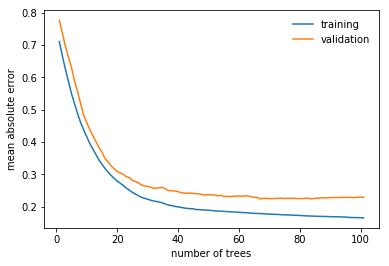

In [158]:
tree_indices = np.arange(len(val_errors)) + 1
plt.plot(tree_indices, train_errors, label='training')
plt.plot(tree_indices, val_errors, label='validation')
plt.xlabel('number of trees')
plt.ylabel('mean absolute error')
plt.legend(loc='best');

### Early stopping

In [155]:
patience = 5
gbr = GradientBoostingRegressor(learning_rate=0.1, max_depth=8, min_samples_leaf=3,
                                n_estimators=1, warm_start=True)

best_error = np.inf

for i in range(100):
    gbr.set_params(n_estimators=i + 1)
    gbr.fit(X_train_small, y_train_small)
    val_error = median_absolute_error(y_test, gbr.predict(X_test))
    if val_error < best_error:
        best_error = val_error
    else:
        patience -= 1
        if patience < 0:
            print('Converged at tree #%d' % (i + 1))
            break

Converged at tree #49


### Randomized paramater search with early stopping

This feature is being implemented directly in scikit-learn as part of [PR #5689](https://github.com/scikit-learn/scikit-learn/pull/5689) but can be implemented manually easily in the mean time.

Important hyper-parameters:

- `loss`
- `n_estimators`
- `max_depth` (typically much smaller than for random forests)
- `min_samples_leaf` (help reduce the trees / model size and prediction speed)

### Probability calibration for classification confidence

Example application: realtime bidding: bid ~= CTR * expected revenue per click. CTR is a likelihood o clicking and can be estimated by the confidence level of the model.

For a recommender system, it might be interesting to put a threshold on the items you recommend to a specific user in a specific context-based: 3 good recommendations rather than 10 recommendations with 7 garbage. In order for this threshold to stay meaningful when you change the way you train the models, it might be a good idea to calibrate the model confidence level.

`GradientBoostingClassifier` has a `predict_proba` method but what it returns tend to be mis-calibrated by default (similar to Support Vector Machines). It might be necessary to use Platt-scaling or Isotonic regression to recalibrate the model via cross-validation.

See: http://scikit-learn.org/stable/modules/calibration.html

### Categorical features encoded as integers

## Limitations

###  Regression with homogeneous feature interactions

Trees required to approximate X1−X2:

10 trees:

<img 
  width="50%"
  src="http://nbviewer.jupyter.org/github/pprett/pydata-gbrt-tutorial/blob/master/func_approx_minus_2.png" />
  
1000 trees:

<img 
  width="50%"
  src="http://nbviewer.jupyter.org/github/pprett/pydata-gbrt-tutorial/blob/master/func_approx_minus_3.png" />
  
Credits: https://github.com/pprett/pydata-gbrt-tutorial

### Multiclass classification

Training time, model size and prediction latency scale linearly with the number of classes...

Possibly better models for multiclass classification with a large number of classes:

- Random Forests
- Linear models: multi-nomial logistic regression: might require extensive feature engineering to model non-linear interactions in original space. Nystrom method migth be useful.
- Neural Networks (MLP)

### High-dimensional feature spaces

GBRT models tend to work better on lower dimensional space (typically less than 500 features). Using feature importances or other feature selection might help focus the feature engineering effort.

For very high-dimensional data, linear models will be much faster to train and possibly yield much better results. GBRT models can still be useful to blend predictions of other models, for instance:

- free text fields in database columns + few numeric or categorical fields
- train one TF-IDF (Bag of Words features) + logistic regression model per free text field
- train a GBRT model that uses logistic regression models' probabilistic predictions concatenated with numerical and (integer coded) categorical fields to compute the final predictions.

## XGBoost

XGBoost provides a more efficient implementation and notably supports multi-threading via a scikit-learn compatible interface. 

It also supports out-of-core and distributed model fitting although via a different API.

Most of the practical recommendations of this guide still apply when using XGBoost instead of scikit-learn models.

In [36]:
%%time
from xgboost import XGBRegressor

xgbr = XGBRegressor(learning_rate=0.1, max_depth=8, n_estimators=50)
xgbr.fit(X_train, y_train)
print("train error: %0.3f, test error: %0.3f" %
      (median_absolute_error(y_train, xgbr.predict(X_train)),
       median_absolute_error(y_test, xgbr.predict(X_test))))

train error: 0.161, test error: 0.201
CPU times: user 13.1 s, sys: 0 ns, total: 13.1 s
Wall time: 4.19 s


In [164]:
%time _ = xgbr.predict(X_test[:100])

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 2.03 ms
